# Step 1: Import Libraries and Load Dataset

In [136]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import joblib
import warnings

warnings.filterwarnings('ignore')

# Load the dataset

data = pd.read_csv('dataset\kaggle_bot_accounts.csv')

# Step 2: Exploratory Data Analysis (EDA)

Dataset shape: (1321188, 17)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321188 entries, 0 to 1321187
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1321188 non-null  int64  
 1   NAME                   1243024 non-null  object 
 2   GENDER                 1243309 non-null  object 
 3   EMAIL_ID               1243374 non-null  object 
 4   IS_GLOGIN              1243272 non-null  object 
 5   FOLLOWER_COUNT         1243476 non-null  float64
 6   FOLLOWING_COUNT        1242743 non-null  float64
 7   DATASET_COUNT          1242621 non-null  float64
 8   CODE_COUNT             1243262 non-null  float64
 9   DISCUSSION_COUNT       1243466 non-null  float64
 10  AVG_NB_READ_TIME_MIN   1242872 non-null  float64
 11  REGISTRATION_IPV4      1242859 non-null  object 
 12  REGISTRATION_LOCATION  1242898 non-null  object 
 13  TOTAL_VOTES_GAVE_NB    12434

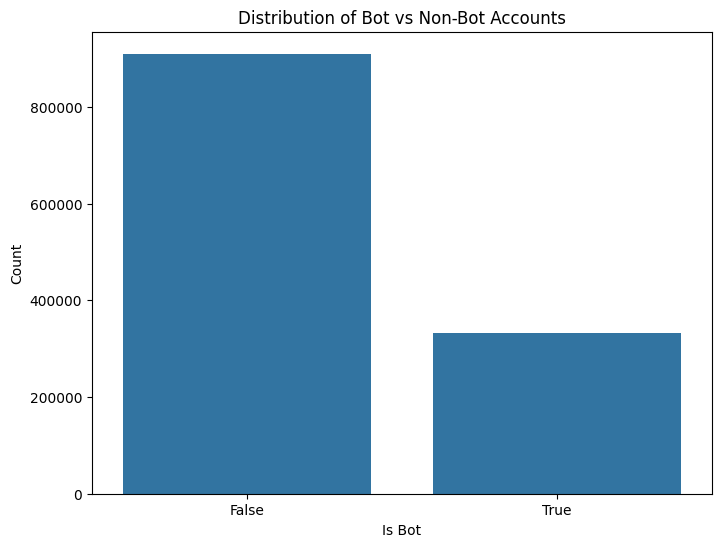

In [137]:
# Display basic information about the dataset
print("Dataset shape:", data.shape)
print("\nDataset info:")
data.info()

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Display summary statistics
print("\nSummary statistics:")
print(data.describe())

# Check target variable distribution
print("\nTarget variable distribution:")
print(data['ISBOT'].value_counts())
print(data['ISBOT'].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='ISBOT', data=data)
plt.title('Distribution of Bot vs Non-Bot Accounts')
plt.xlabel('Is Bot')
plt.ylabel('Count')
plt.show()

# Step 3: Data Cleaning and Preprocessing

In [ ]:
# Remove duplicate rows
print("Before removing duplicates:", data.shape)
data = data.drop_duplicates()
print("After removing duplicates:", data.shape)

# Handle missing values - examine each column with missing values
columns_with_na = data.columns[data.isnull().any()].tolist()
print(f"Columns with missing values: {columns_with_na}")

# For each column with missing values, analyze the distributio
for column in columns_with_na:
    if data[column].dtype == 'object':
        print(f"\nMost frequent values in {column}:")
        print(data[column].value_counts().head())
    else:
        print(f"\nStatistics for {column}:")
        print(data[column].describe())

# Impute missing values based on the analysis
# For numerical columns, use median for imputation
# For categorical columns, use most frequent value

# Create different imputation strategies based on data type
num_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_columns = data.select_dtypes(include=['object']).columns.tolist()

# Remove target from lists if present
if 'ISBOT' in num_columns:
    num_columns.remove('ISBOT')
if 'ISBOT' in cat_columns:
    cat_columns.remove('ISBOT')

# Create preprocessing pipelines for numerical and categorical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat', cat_pipeline, cat_columns)
])

# Apply preprocessing and prepare data for model training
X = data.drop('ISBOT', axis=1)
y = data['ISBOT']



Before removing duplicates: (1321188, 17)
After removing duplicates: (1321188, 17)
Columns with missing values: ['NAME', 'GENDER', 'EMAIL_ID', 'IS_GLOGIN', 'FOLLOWER_COUNT', 'FOLLOWING_COUNT', 'DATASET_COUNT', 'CODE_COUNT', 'DISCUSSION_COUNT', 'AVG_NB_READ_TIME_MIN', 'REGISTRATION_IPV4', 'REGISTRATION_LOCATION', 'TOTAL_VOTES_GAVE_NB', 'TOTAL_VOTES_GAVE_DS', 'TOTAL_VOTES_GAVE_DC', 'ISBOT']

Most frequent values in NAME:
NAME
David SmithSmith          17
Michael JohnsonJohnson    16
Michael JohnsonSmith      15
Robert SmithSmith         15
John JohnsonJohnson       15
Name: count, dtype: int64

Most frequent values in GENDER:
GENDER
Male      932220
Female    311089
Name: count, dtype: int64

Most frequent values in EMAIL_ID:
EMAIL_ID
csmith@example.org    117
rsmith@example.net    108
ssmith@example.net    107
dsmith@example.com    106
rsmith@example.com    105
Name: count, dtype: int64

Most frequent values in IS_GLOGIN:
IS_GLOGIN
False    788359
True     454913
Name: count, dtype: int

# Step 4: Feature Analysis and Selection

In [139]:
data.isnull().sum()

Unnamed: 0                   0
NAME                     78164
GENDER                   77879
EMAIL_ID                 77814
IS_GLOGIN                77916
FOLLOWER_COUNT           77712
FOLLOWING_COUNT          78445
DATASET_COUNT            78567
CODE_COUNT               77926
DISCUSSION_COUNT         77722
AVG_NB_READ_TIME_MIN     78316
REGISTRATION_IPV4        78329
REGISTRATION_LOCATION    78290
TOTAL_VOTES_GAVE_NB      77705
TOTAL_VOTES_GAVE_DS      77934
TOTAL_VOTES_GAVE_DC      78030
ISBOT                    78500
dtype: int64

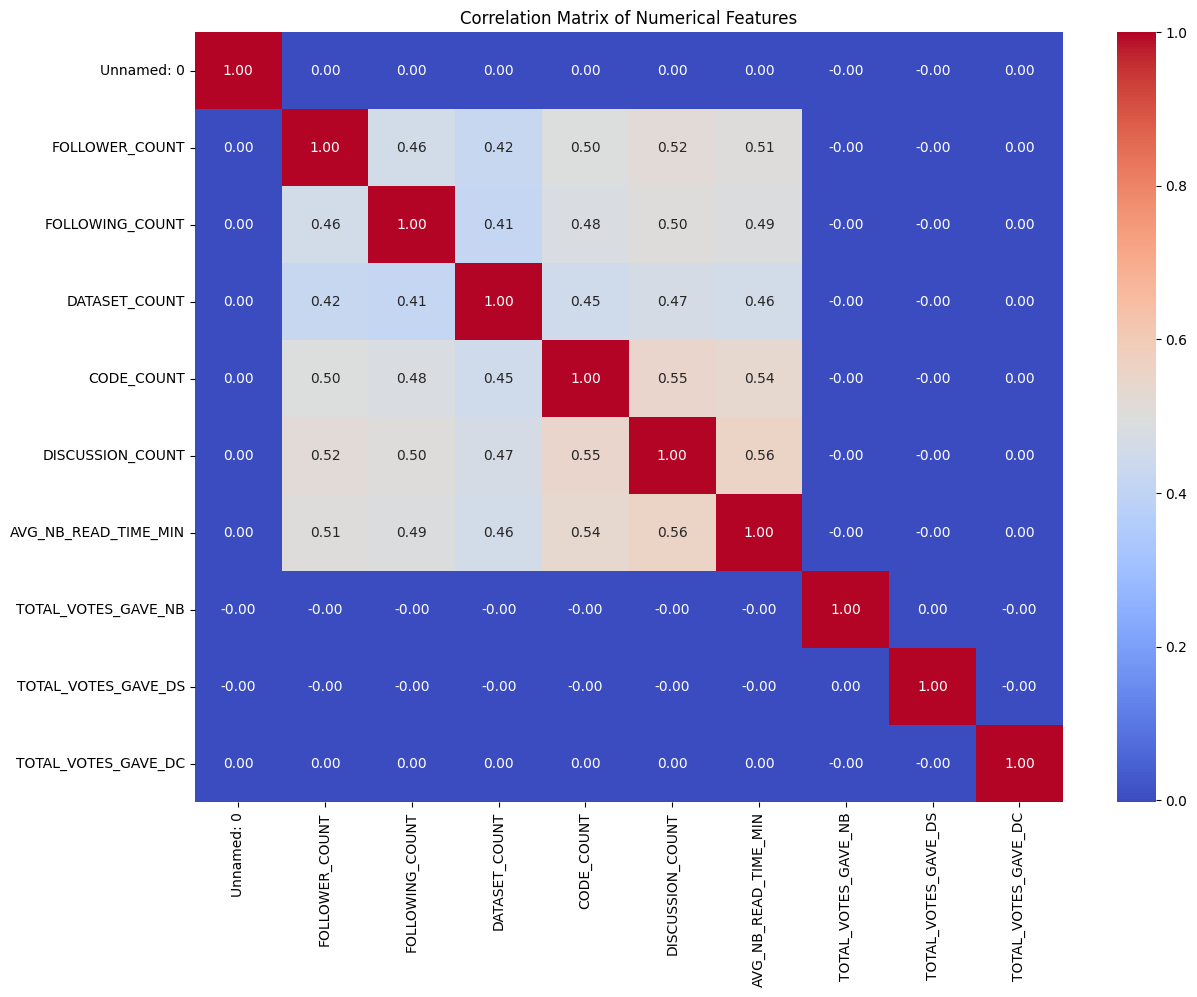

Highly correlated feature pairs:
FOLLOWER_COUNT and FOLLOWING_COUNT: 0.46
FOLLOWER_COUNT and DATASET_COUNT: 0.42
FOLLOWER_COUNT and CODE_COUNT: 0.50
FOLLOWER_COUNT and DISCUSSION_COUNT: 0.52
FOLLOWER_COUNT and AVG_NB_READ_TIME_MIN: 0.51
FOLLOWING_COUNT and DATASET_COUNT: 0.41
FOLLOWING_COUNT and CODE_COUNT: 0.48
FOLLOWING_COUNT and DISCUSSION_COUNT: 0.50
FOLLOWING_COUNT and AVG_NB_READ_TIME_MIN: 0.49
DATASET_COUNT and CODE_COUNT: 0.45
DATASET_COUNT and DISCUSSION_COUNT: 0.47
DATASET_COUNT and AVG_NB_READ_TIME_MIN: 0.46
CODE_COUNT and DISCUSSION_COUNT: 0.55
CODE_COUNT and AVG_NB_READ_TIME_MIN: 0.54
DISCUSSION_COUNT and AVG_NB_READ_TIME_MIN: 0.56


ValueError: Input contains NaN

In [140]:
# Check correlation between numerical features
plt.figure(figsize=(14, 10))
correlation_matrix = data[num_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Identify highly correlated features
high_corr_threshold = 0.3
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print("Highly correlated feature pairs:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

temp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

temp_pipeline.fit(X, y)

# Get feature names after one-hot encoding
feature_names = []
for name, _, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    else:  # 'cat'
        for col in cols:
            encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
            feature_names.extend([f"{col}_{category}" for category in encoder.categories_[list(cols).index(col)]])

# Get feature importances
importances = temp_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names[:len(importances)],  # Ensure lengths match
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Step 5: Handle Imbalanced Dataset

In [ ]:
# Check class imbalance
class_counts = y.value_counts()
print("Class distribution before balancing:")
print(class_counts)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Only apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(
    preprocessor.fit_transform(X_train), y_train
)

print("\nClass distribution after balancing:")
print(pd.Series(y_train_resampled).value_counts())

# Visualize balanced data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y)
plt.title('Original Class Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Balanced Class Distribution')
plt.tight_layout()
plt.show()

# Step 6: Hyperparameter Tuning and Cross-Validation

In [ ]:
# Define base models for ensemble
models = {
    'random_forest': RandomForestClassifier(random_state=42),
    'gradient_boosting': GradientBoostingClassifier(random_state=42),
    'logistic_regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Define parameter grids for each model
param_grids = {
    'random_forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'gradient_boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'logistic_regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

# Perform hyperparameter tuning with cross-validation for each model
best_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\nTuning hyperparameters for {model_name}...")
    
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline([
        ('classifier', model)
    ])
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search to the data
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the best model
    best_models[model_name] = grid_search.best_estimator_
    
    # Print results
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred = grid_search.predict(preprocessor.transform(X_test))
    test_accuracy = accuracy_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_pred)
    
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Bot', 'Bot'], 
                yticklabels=['Non-Bot', 'Bot'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Step 7: Implement Ensemble Learning

In [ ]:
# Create a voting classifier using the best models
voting_classifier = VotingClassifier(
    estimators=[
        ('random_forest', best_models['random_forest']),
        ('gradient_boosting', best_models['gradient_boosting']),
        ('logistic_regression', best_models['logistic_regression'])
    ],
    voting='soft'  # Use probability estimates for voting
)

# Train the ensemble model
voting_classifier.fit(X_train_resampled, y_train_resampled)

# Evaluate the ensemble model
y_pred_ensemble = voting_classifier.predict(preprocessor.transform(X_test))
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_roc_auc = roc_auc_score(y_test, y_pred_ensemble)

print(f"Ensemble model test accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble model test ROC AUC: {ensemble_roc_auc:.4f}")
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

# Plot confusion matrix for ensemble model
plt.figure(figsize=(8, 6))
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Bot', 'Bot'], 
            yticklabels=['Non-Bot', 'Bot'])
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Compare all models
models_comparison = {
    'Random Forest': best_models['random_forest'],
    'Gradient Boosting': best_models['gradient_boosting'],
    'Logistic Regression': best_models['logistic_regression'],
    'Ensemble': voting_classifier
}

results = {}
for name, model in models_comparison.items():
    # Make predictions
    if name != 'Ensemble':
        y_pred = model.predict(preprocessor.transform(X_test))
    else:
        y_pred = y_pred_ensemble
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc
    }

# Create a DataFrame for comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Plot comparison
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 8: Final Model Training and Saving

In [ ]:
# Create the final pipeline with preprocessing and the best model (ensemble)
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', voting_classifier)
])

# Fit the final pipeline to the entire dataset
print("Training final model on the entire dataset...")
X_resampled, y_resampled = smote.fit_resample(X, y)
final_pipeline.fit(X_resampled, y_resampled)

# Save the model
print("Saving the model...")
joblib.dump(final_pipeline, '../model/kaggle_bot_detection_model.pkl')
print("Model saved successfully!")

# Save the feature names for future reference
feature_names_dict = {
    'numerical_features': num_columns,
    'categorical_features': cat_columns
}
joblib.dump(feature_names_dict, '../model/feature_names.pkl')
print("Feature names saved successfully!")

# Step 9: Model Interpretation

In [ ]:
# Analyze feature importance from the Random Forest component of the ensemble
rf_model = best_models['random_forest']
feature_importances = rf_model.named_steps['classifier'].feature_importances_

# Get feature names after preprocessing
feature_names = []
for name, _, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    else:  # 'cat'
        for col in cols:
            encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
            feature_names.extend([f"{col}_{category}" for category in encoder.categories_[list(cols).index(col)]])

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_importances)],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Precision-Recall curve analysis
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.grid(True)
plt.show()

# Step 10: Create Prediction Function for API Integration

In [ ]:
# Create a function that can be used in the FastAPI backend
def predict_bot_status(input_data):
    """
    Predict if a Kaggle account is a bot based on input features.
    
    Parameters:
    -----------
    input_data : dict
        Dictionary containing user account features
    
    Returns:
    --------
    dict
        Prediction result including bot status and probability
    """
    # Convert input_data to a DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Load the model and feature names
    model = joblib.load('../model/kaggle_bot_detection_model.pkl')
    
    # Make prediction
    prediction = model.predict(input_df)[0]
    probability = model.predict_proba(input_df)[0][1]  # Probability of being a bot
    
    return {
        "is_bot": bool(prediction),
        "bot_probability": float(probability),
        "prediction_confidence": float(probability if prediction else 1-probability)
    }

# Test the prediction function with a sample input
sample_input = {
    # Sample features based on the dataset columns
    # To be filled with actual features from your dataset
}

# Uncomment to test the prediction function
# print(predict_bot_status(sample_input))

# Step 11: Summary and Conclusion

In [ ]:
# Summary of the project
print("Project Summary:")
print("-" * 50)
print("1. Data Exploration:")
print(f"   - Dataset Shape: {data.shape}")
print(f"   - Features: {len(X.columns)}")
print(f"   - Target Distribution: {y.value_counts().to_dict()}")

print("\n2. Data Preprocessing Steps:")
print("   - Removed duplicate entries")
print("   - Handled missing values using appropriate imputation strategies")
print("   - Applied feature scaling for numerical features")
print("   - Applied one-hot encoding for categorical features")
print("   - Balanced the dataset using SMOTE")

print("\n3. Model Evaluation:")
for model_name, metrics in results.items():
    print(f"   - {model_name}: Accuracy = {metrics['Accuracy']:.4f}, ROC AUC = {metrics['ROC AUC']:.4f}")

print("\n4. Final Model:")
print(f"   - Type: Ensemble (Voting Classifier)")
print(f"   - Performance: Accuracy = {ensemble_accuracy:.4f}, ROC AUC = {ensemble_roc_auc:.4f}")

print("\n5. Top Features:")
for feature, importance in importance_df.head(5).values:
    print(f"   - {feature}: {importance:.4f}")

print("\nConclusion:")
print("The final ensemble model effectively identifies bot accounts on Kaggle with high accuracy.")
print("This model has been saved and can be integrated with the FastAPI backend for real-time predictions.")